# Code to calculate desired evaluation metrics from best run timeseries

## import library and define functions

In [26]:
import numpy as np
import yaml
import os
import warnings
import json
import hydroeval as he
import pandas as pd
from tqdm import tqdm
import hydroeval as he

In [31]:
def calculate_nse(modeled_data, observed_data):
    mean_observed = np.mean(observed_data)
    numerator = np.sum(np.power(observed_data - modeled_data, 2))
    denominator = np.sum(np.power(observed_data - mean_observed, 2))
    return 1 - np.divide(numerator, denominator)

def load_basin_list(basin_filename):
    with open(basin_filename, 'r') as file:
        lines = file.readlines()
        # Remove leading/trailing whitespaces and newline characters
        lines = [line.strip() for line in lines]
    basin_list_str = lines
    return basin_list_str

def load_time_index(time_split_file):
    with open(time_split_file) as f:
        time_split = json.load(f)
        print(time_split)
        start_time = time_split['testing']['start_datetime']
        end_time = time_split['testing']['end_datetime']
        hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')
    return hourly_index, start_time, end_time

def load_best_run_timeseries(best_runs_dir, basin_id, hourly_index):
    best_runs_files = os.listdir(best_runs_dir)
    best_run_for_a_basin = [file_name for file_name in best_runs_files if basin_id in file_name]
    if len(best_run_for_a_basin) == 1:
        with open(os.path.join(best_runs_dir, best_run_for_a_basin[0])) as f:
            best_run = json.load(f)
    elif len(best_run_for_a_basin) == 0:
        warnings.warn("No calibration was done for this basin")
    elif len(best_run_for_a_basin) > 1:
        warnings.warn("Multiple calibration runs are mixed up in one folder, check")
    best_run_timeseries = pd.DataFrame(best_run['simulated_Q(mm/h)'], columns=['simulated'])
    best_run_timeseries.set_index(hourly_index, inplace=True)
    return best_run_timeseries
    
def load_obs_timeseries(obs_data_dir, start_time, end_time, basin_id):
    obs_data_files = os.listdir(obs_data_dir)
    obs_data_file = [file_name for file_name in obs_data_files if file_name.startswith(basin_id)]

    if len(obs_data_file)==1:
        obs_data_ = pd.read_csv(os.path.join(obs_data_dir, obs_data_file[0]))
    else:
        warnings.warn("data is gone!")
        
    obs_data_['date'] = pd.to_datetime(obs_data_['date'])
    obs_data_.set_index(obs_data_['date'], inplace=True)
    obs_data = obs_data_[start_time:end_time]
    
    return obs_data

def load_forcing_timeseries(forcing_data_dir, start_time, end_time, basin_id):
    forcing_data_files = os.listdir(forcing_data_dir)
    forcing_data_file = [file_name for file_name in forcing_data_files if file_name.startswith(basin_id)]

    if len(forcing_data_file)==1:
        forcing_data_ = pd.read_csv(os.path.join(forcing_data_dir, forcing_data_file[0]))
    else:
        warnings.warn("data is gone!")
        
    forcing_data_['date'] = pd.to_datetime(forcing_data_['date'])
    forcing_data_.set_index(forcing_data_['date'], inplace=True)
    forcing_data = forcing_data_[start_time:end_time]
    
    return forcing_data

    

## Read configs

In [32]:
# Read the config file
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Access the config variables
results_dir = config['io_dir']['results_dir'].replace("${cwd}", "..")
best_runs_dir = r'G:\Shared drives\SI_NextGen_Aridity\calibrate_cfe\results\Testing-07July2023\Testing\runs'  #os.path.join(results_dir, 'best_runs', '')
basin_filename = config['model_settings']['basin_file'].replace("${cwd}", "..")
time_split_file = config['model_settings']['time_split_file'].replace("${cwd}", "..")
obs_data_dir = config['io_dir']['usgs_streamflow_dir'].replace("${cwd}", "..")
forcing_data_dir = config['io_dir']['nldas_forcing_dir'].replace("${cwd}", "..")

## Loop through basins and evaluate

In [36]:
# Initialize
basin_list_str = load_basin_list(basin_filename)
df_results = pd.DataFrame(columns=['BasinID', 'NSE', 'NNSE', 'logNSE', 'KGE', 'logKGE'])
plot_results = False

# # To test one basin
# i=0
basin_id = '09447800'
# for basin_id in ([basin_list_str[i]]):

# # Loop through all the basins
# for basin_id in tqdm(basin_list_str):

# Load time split
hourly_index, start_time, end_time = load_time_index(time_split_file)

# Load and combine obs & simulated data 
best_run_timeseries = load_best_run_timeseries(best_runs_dir=best_runs_dir, basin_id=basin_id, hourly_index=hourly_index)
obs_data = load_obs_timeseries(obs_data_dir=obs_data_dir, start_time=start_time, end_time=end_time, basin_id=basin_id)
forcing_data = load_forcing_timeseries(forcing_data_dir=forcing_data_dir, start_time=start_time, end_time=end_time, basin_id=basin_id)
df_eval_sim_ = obs_data.join(best_run_timeseries)


{'spinup-for-calibration': {'start_datetime': '1998-10-01 00:00:00', 'end_datetime': '1999-09-30 23:00:00', 'note': 'Used for CFE model spin-up by 2023 team (1yr before calibration period)'}, 'calibration': {'start_datetime': '1999-10-01 00:00:00', 'end_datetime': '2008-09-30 23:00:00', 'note': 'Used for calibrating CFE model & training LSTM by 2023 team. Based on previous studies (Frame et al., 2022; Kratzert et al., 2019; Hoedt et al., 2021; Kratzert et al., 2021)'}, 'spinup-for-testing': {'start_datetime': '2008-10-01 00:00:00', 'end_datetime': '2009-09-30 23:00:00', 'note': 'Used for CFE model spin-up by 2023 team (1yr before testing period)'}, 'testing': {'start_datetime': '2009-10-01 00:00:00', 'end_datetime': '2010-09-30 23:00:00', 'note': "Used for checking CFE & LSTM performance after calibration by 2023 team. No validation (hyper-parameter tuning) performed for LSTM. 1990 doesn't have much data"}}


In [43]:
df_eval_sim = df_eval_sim_.join(forcing_data.drop(columns='date'))


                                   date  QObs(mm/h)  QObs count qualifiers  \
date                                                                         
2009-10-01 00:00:00 2009-10-01 00:00:00    0.000125           4    A/A/A/A   
2009-10-01 01:00:00 2009-10-01 01:00:00    0.000125           4    A/A/A/A   
2009-10-01 02:00:00 2009-10-01 02:00:00    0.000125           4    A/A/A/A   
2009-10-01 03:00:00 2009-10-01 03:00:00    0.000126           4    A/A/A/A   
2009-10-01 04:00:00 2009-10-01 04:00:00    0.000130           4    A/A/A/A   

                     utcoffset(h)  (iv-camels)/camels  QObs_CAMELS(mm/h)  \
date                                                                       
2009-10-01 00:00:00          -7.0            0.015729            0.00013   
2009-10-01 01:00:00          -7.0            0.015729            0.00013   
2009-10-01 02:00:00          -7.0            0.015729            0.00013   
2009-10-01 03:00:00          -7.0            0.015729            0.00013 

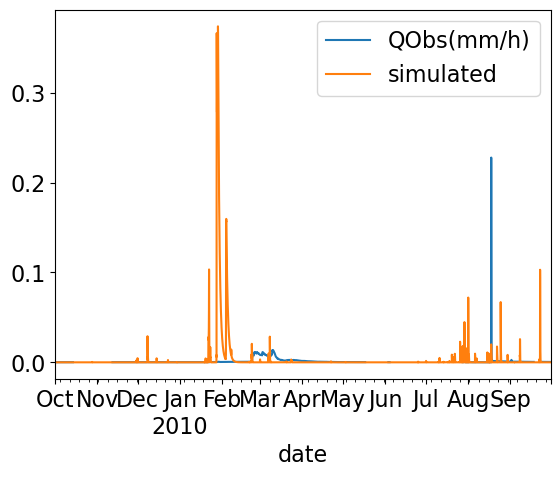

In [44]:
import matplotlib.pyplot as plt
# plot sim against obs for the 1st year

fig, ax1 = plt.subplots(figsize = (18,12)) 
p1, = ax1.plot(df_eval_sim['simulated_Q(mm/h)'],'tomato', linewidth = 2,label = "sim")
p2, = ax1.plot(dates,obs_data,'k',label = "obs")
ax1.set_ylabel('Discharge (mm/h)',fontsize = 26)
ax1.set_ylim([0,2])
ax1.tick_params(axis='x', labelsize= 24)
ax1.tick_params(axis='y', labelsize= 24)
ax1.margins(x=0)
ax1.xaxis.set_ticks_position('both')
ax1.xaxis.set_label_position('bottom')
ax1.tick_params(axis="x",direction="in")
ax2 = ax1.twinx()
p3, = ax2.plot(dates,df_forcing['total_precipitation'],'tab:blue', label = "precip")
ax2.set_ylim([50,0])
ax2.margins(x=0)
#ax2.invert_yaxis()
ax2.set_ylabel('Precipitation (mm/h)',fontsize = 26)
ax2.set_xlabel('Date', fontsize = 18)
#ax2.tick_params(axis='x', labelsize= 24)
ax2.tick_params(axis='y', labelsize= 24)
plt.legend(handles = [p1,p2,p3],fontsize = 24, loc='lower right', bbox_to_anchor=(0.5, 0.5,0.5,0.5))
textstr = '\n'.join((f"The KGE value is : {round(kge[0],4)}.",f"The NSE value is : {round(nse[0],4)}."))
ax1.text(0.98, 0.45, textstr, transform=ax1.transAxes, fontsize=20,verticalalignment='center',horizontalalignment='right',bbox=dict(facecolor='white', alpha=0.5))
plt.title(f"Simulated Streamflow against Observation in the Testing Period [ID: 0{g_str}]", fontsize = 28)
plt.tight_layout()
# If you want to plot results
# plot_results = True
# if plot_results: 
#     print(df_eval_sim.head())
#     df_eval_sim[['QObs(mm/h)', 'simulated']].plot()

# # Get desired columns
# modeled_data_ = df_eval_sim['simulated'].values
# observed_data_ = df_eval_sim['QObs(mm/h)'].values

# # Skip nan values in the observed data
# modeled_data = modeled_data_[~np.isnan(observed_data_)]
# observed_data = observed_data_[~np.isnan(observed_data_)]


In [30]:

# # Evalute (you can add as many eval metrics here)
# nse = calculate_nse(modeled_data=modeled_data, observed_data=observed_data)
# nnse = 1/(2-nse)
# lognse = calculate_nse(modeled_data=np.log(modeled_data), observed_data=np.log(observed_data))
# kge = he.evaluator(he.kge, simulations=modeled_data, evaluations=observed_data)
# logkge = he.evaluator(he.kge, simulations=np.log(modeled_data), evaluations=np.log(observed_data))

# df_results = pd.concat([df_results, pd.DataFrame({
#     'BasinID': [basin_id], 
#     'NSE': [nse], 
#     'NNSE':[nnse], 
#     'logNSE':[lognse],
#     'KGE':[kge],
#     'logKGE': [logkge]
#     })])

# # Reset the index of the DataFrame
# df_results = df_results.reset_index(drop=True)

# # Print the results DataFrame
# print(df_results)
# df_results.to_csv(os.path.join(best_runs_dir, 'best_runs_eval.csv'))